In [1]:
import yaml
import sys
import os

from segment_anything import build_sam, SamAutomaticMaskGenerator
from segment_anything import SamPredictor, sam_model_registry
import torchvision.transforms as transforms
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
import torch.nn.functional as F
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import cv2

from misc.InpaintGAN import InpaintGenerator

In [2]:
ROOT_PATH  = os.getcwd()
DATA_PATH  = f'{ROOT_PATH}/data'
MODEL_PATH = f'{ROOT_PATH}/checkpoint/sam_vit_h.pth'

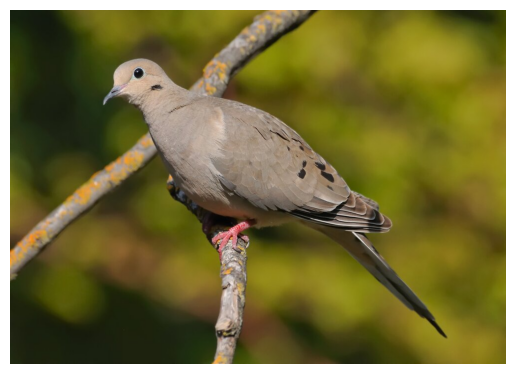

In [3]:
device        = 'cuda' if torch.cuda.is_available() else 'cpu'
image         = np.array(Image.open(f'{DATA_PATH}/dove.jpg').convert('RGB'))

plt.imshow(image)
plt.axis(False)
plt.show()

In [4]:
model        = build_sam(checkpoint = MODEL_PATH).to(device)
generator    = SamAutomaticMaskGenerator(model)

/opt/conda/envs/torch/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
masks        = generator.generate(image)

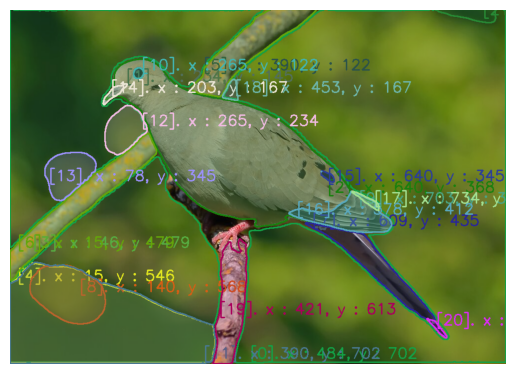

In [6]:
image_cp     = image.copy()
random_color = lambda : np.random.randint(0, 256)


for idx, mask in enumerate(masks):
    
    x, y         = list(map(int, mask['point_coords'][0]))
    seg          = mask['segmentation']
    seg          = seg + np.zeros(seg.shape, np.uint8)
    _, bin_image = cv2.threshold(seg, 0, 127, cv2.THRESH_BINARY)
    
    
    color        = (random_color(), random_color(), random_color())
    masked_image = np.where(seg[..., None], color, image_cp)
    image_cp     = cv2.addWeighted(image_cp, 0.8, masked_image, 0.2, 0, dtype = cv2.CV_32F)
    
    conts, _     = cv2.findContours(bin_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for cont in conts: cv2.drawContours(image_cp, [cont], -1, color, 2)
    
    cv2.putText(image_cp, f'[{idx}]. x : {x}, y : {y}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 2)
plt.imshow(image_cp.astype(np.uint32))
plt.axis(False)

os.makedirs('data/output_AOT/dove/', exist_ok = True)
cv2.imwrite('data/output_AOT/dove/masked.png', image_cp)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy().squeeze() if tensor.requires_grad else tensor.cpu().numpy().squeeze()

In [7]:
args = {}
args['input_image']  = DATA_PATH
args['coords_type']  = 'key_in'
args['point_coords'] = masks[19]['point_coords']
args['point_label']  = [1]
args['output_dir']   = f'{DATA_PATH}/output'
args['lama_config']  = f'{ROOT_PATH}/IA/lama/configs/prediction/default.yaml'
args['lama_ckpt']    = f'{ROOT_PATH}/checkpoint/'

args = edict(args)

In [8]:
point_coords = np.array(args.point_coords)
point_label  = np.array(args.point_label)

sam          = sam_model_registry['vit_h'](checkpoint = MODEL_PATH).to(device)
predictor    = SamPredictor(sam)

In [9]:
point_coords, point_label

(array([[421.875  , 613.59375]]), array([1]))

In [10]:
coords = torch.as_tensor(point_coords)
coords.size()

torch.Size([1, 2])

In [11]:
predictor.set_image(image)
masks_, _, _ = predictor.predict(
                point_coords     = point_coords,
                point_labels     = point_label,
                multimask_output = False
            )

In [12]:
masks_   = masks_.astype(np.uint8) * 255
img_stem = Path(DATA_PATH).stem
out_dir  = Path(args.output_dir) / img_stem
out_dir.mkdir(parents = True, exist_ok = True)

image_  = Image.fromarray(image)
masks_  = Image.fromarray(masks_.squeeze())

(-0.5, 999.5, 713.5, -0.5)

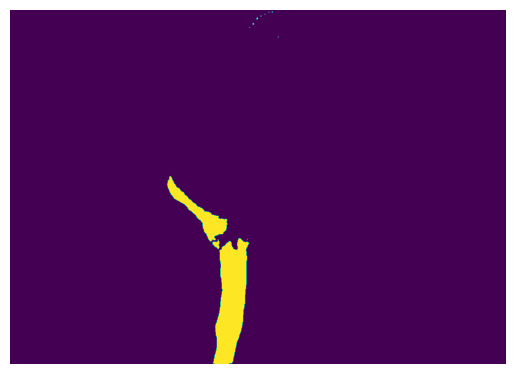

In [13]:
transform = transforms.Compose([
                transforms.Resize([256, 256]),
                transforms.ToTensor()
            ])

plt.imshow(masks_)
plt.axis(False)

In [14]:
image = transform(image_.convert('RGB')).unsqueeze(axis = 0)
mask  = transform(masks_.convert('L')).unsqueeze(axis = 0)

image.size(), mask.size()

(torch.Size([1, 3, 256, 256]), torch.Size([1, 1, 256, 256]))

In [15]:
args = {}
args['rates']     = '1+2+4+8'
args['block_num'] = 8
args['pre_train'] = 'data/models/generator.pt'
args['model'] = 'aotgan'
args = edict(args)

args.rates = list(map(int, list(args.rates.split("+"))))
args.rates

[1, 2, 4, 8]

In [16]:
model = InpaintGenerator(args)
model.load_state_dict(torch.load(args.pre_train, map_location=torch.device(device)))
model.eval()

InpaintGenerator(
  (encoder): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
  )
  (middle): Sequential(
    (0): AOTBlock(
      (block00): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU(inplace=True)
      )
      (block01): Sequential(
        (0): ReflectionPad2d((2, 2, 2, 2))
        (1): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
        (2): ReLU(inplace=True)
      )
      (block02): Sequential(
        (0): ReflectionPad2d((4, 4, 4, 4))
        (1): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), dilation=(4, 4))
        (2): ReLU(inplace=True)
      )
      (block03

(-0.5, 255.5, 255.5, -0.5)

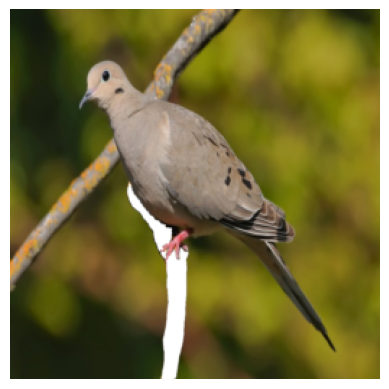

In [17]:
masked_image = (image * (1 - mask).float()) + mask
plt.imshow(np.transpose(to_numpy(masked_image), (1, 2, 0)))
plt.axis(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

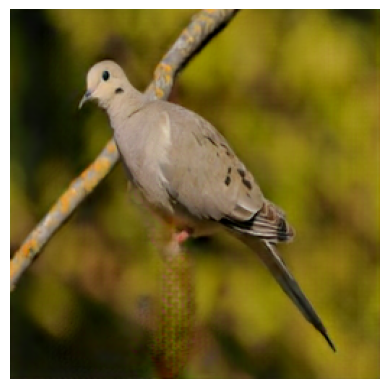

In [18]:
result = model.forward(masked_image, mask)
plt.imshow(np.transpose(to_numpy(result), (1, 2, 0)))
plt.axis(False)